In [3]:
import brian2 as b2
from brian2 import NeuronGroup, Synapses, PoissonInput, PoissonGroup, network_operation
from brian2.monitors import StateMonitor, SpikeMonitor, PopulationRateMonitor
from random import sample
import numpy.random as rnd
from neurodynex3.tools import plot_tools
import numpy
import matplotlib.pyplot as plt
from math import floor
import time

b2.defaultclock.dt = 0.10 * b2.ms

In [4]:
N_Excit=384 
N_Inhib=96 
weight_scaling_factor=5.33
t_stimulus_start=100 * b2.ms 
t_stimulus_duration=9999 * b2.ms 
coherence_level=0
stimulus_update_interval=30 * b2.ms
mu0_mean_stimulus_Hz=160
w_pos=1.90
firing_rate_extern=9.8 * b2.Hz
N_extern=1000 
stimulus_std_Hz=20.
f_Subpop_size=0.25  # .15 in publication [1]
max_sim_time=1000. * b2.ms 
stop_condition_rate=None
monitored_subset_size=512

In [5]:
weight_scaling_factor = 5.33
f_Subpop_size=0.25
w_pos=1.90
firing_rate_extern=9.8 * b2.Hz,    
N_extern=1000
    
Cm_excit = 0.5 * b2.nF  # membrane capacitance of excitatory neurons0
G_leak_excit = 25.0 * b2.nS  # leak conductance
E_leak_excit = -70.0 * b2.mV  # reversal potential
v_spike_thr_excit = -50.0 * b2.mV  # spike condition
v_reset_excit = -60.0 * b2.mV  # reset voltage after spike
t_abs_refract_excit = 2. * b2.ms  # absolute refractory period

# specify the inhibitory interneurons:
# N_Inhib = 200
Cm_inhib = 0.2 * b2.nF
G_leak_inhib = 20.0 * b2.nS
E_leak_inhib = -70.0 * b2.mV
v_spike_thr_inhib = -50.0 * b2.mV
v_reset_inhib = -60.0 * b2.mV
t_abs_refract_inhib = 1.0 * b2.ms

# specify the AMPA synapses
E_AMPA = 0.0 * b2.mV
tau_AMPA = 2.5 * b2.ms

# specify the GABA synapses
E_GABA = -70.0 * b2.mV
tau_GABA = 5.0 * b2.ms

# specify the NMDA synapses
E_NMDA = 0.0 * b2.mV
tau_NMDA_s = 100.0 * b2.ms
tau_NMDA_x = 2. * b2.ms
alpha_NMDA = 0.5 * b2.kHz

# projections from the external population
g_AMPA_extern2inhib = 1.62 * b2.nS
g_AMPA_extern2excit = 2.1 * b2.nS

# projectsions from the inhibitory populations
g_GABA_inhib2inhib = weight_scaling_factor * 1.25 * b2.nS
g_GABA_inhib2excit = weight_scaling_factor * 1.60 * b2.nS

# projections from the excitatory population
g_AMPA_excit2excit = weight_scaling_factor * 0.012 * b2.nS
g_AMPA_excit2inhib = weight_scaling_factor * 0.015 * b2.nS
g_NMDA_excit2excit = weight_scaling_factor * 0.040 * b2.nS
g_NMDA_excit2inhib = weight_scaling_factor * 0.045 * b2.nS  # stronger projection to inhib.

# weights and "adjusted" weights.
w_neg = 1. - f_Subpop_size * (w_pos - 1.) / (1. - f_Subpop_size)
# We use the same postsyn AMPA and NMDA conductances. Adjust the weights coming from different sources:
w_ext2inhib = g_AMPA_extern2inhib / g_AMPA_excit2inhib
w_ext2excit = g_AMPA_extern2excit / g_AMPA_excit2excit
# other weights are 1
# print("w_neg={}, w_ext2inhib={}, w_ext2excit={}".format(w_neg, w_ext2inhib, w_ext2excit))


In [6]:
initial_value = rnd.uniform(v_spike_thr_inhib / b2.mV - 4., high=v_spike_thr_inhib / b2.mV - 1., size=N_Inhib)

In [7]:
len(initial_value)

96

In [8]:
initial_value.std()

0.780939253019325

In [9]:
excit_lif_dynamics = '''
s_NMDA_total : 1  # the post synaptic sum of s. compare with s_NMDA_presyn
dv/dt = (
- G_leak_excit * (v-E_leak_excit)
- g_AMPA_excit2excit * s_AMPA * (v-E_AMPA)
- g_GABA_inhib2excit * s_GABA * (v-E_GABA)
- g_NMDA_excit2excit * s_NMDA_total * (v-E_NMDA)/(1.0+1.0*exp(-0.062*v/volt)/3.57)
)/Cm_excit : volt (unless refractory)
ds_AMPA/dt = -s_AMPA/tau_AMPA : 1
ds_GABA/dt = -s_GABA/tau_GABA : 1
ds_NMDA/dt = -s_NMDA/tau_NMDA_s + alpha_NMDA * x * (1-s_NMDA) : 1
dx/dt = -x/tau_NMDA_x : 1




'''
    

In [10]:
#G.v = rnd.uniform(E_leak_excit / b2.mV, high=E_leak_excit / b2.mV + 5.) * b2.mV

In [11]:
G = NeuronGroup(1, model = excit_lif_dynamics, threshold="v>v_spike_thr_excit", reset="v=v_reset_excit",
                refractory = t_abs_refract_excit,method="rk2")


In [12]:
from brian2 import *


In [13]:
PoissonInput(target=G, target_var="s_AMPA",
                                 N=N_extern, rate=firing_rate_extern, weight=w_ext2inhib)

PoissonInput(clock=Clock(dt=100. * usecond, name='defaultclock'), when=synapses, order=0, name='poissoninput')

WARNING    Cannot use Cython, a test compilation failed: Microsoft Visual C++ 14.0 or greater is required. Get it with "Microsoft C++ Build Tools": https://visualstudio.microsoft.com/visual-cpp-build-tools/ (DistutilsPlatformError) [brian2.codegen.runtime.cython_rt.cython_rt.failed_compile_test]
INFO       Cannot use compiled code, falling back to the numpy code generation target. Note that this will likely be slower than using compiled code. Set the code generation to numpy manually to avoid this message:
prefs.codegen.target = "numpy" [brian2.devices.device.codegen_fallback]


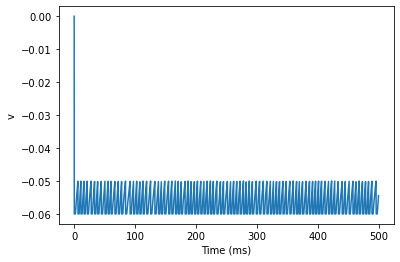

In [14]:

M = StateMonitor(G, 'v', record=True)

b2.run(500*b2.ms)

b2.plot(M.t/b2.ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

In [31]:
poisson2G = PoissonInput(target=G, target_var="s_AMPA",
                             N=1000, rate=firing_rate_extern, weight=w_ext2excit)

In [32]:
M = StateMonitor(G, 'v', record=True)


In [33]:
w_ext2excit

32.833020637898684

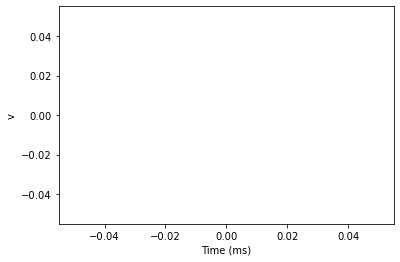

In [34]:
start_scope()


run(500*ms)

plot(M.t/ms, M.v[0])
xlabel('Time (ms)')
ylabel('v');

In [35]:
start_scope()
run(100*ms)
print('Before v = %s' % G.v[0])


Before v = -70. mV


In [36]:
print('After v = %s' % G.v[0])


After v = -70. mV


In [40]:
start_scope()
# Parameters
num_inputs = 100
input_rate = 10*Hz
weight = 0.1

In [41]:
tau_range = linspace(1, 10, 30)*ms
